In [2]:
import os
import glob
import random
import re
import yaml
from collections import Counter, defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
import matplotlib.patches as mpatches

# Report STAR log

Merge STAR log of all samples

In [4]:
array = []
for path in sorted(glob.glob("results/prepare/star/mapped/*/Log.final.out")):
    sample = path.split("/")[-2]
    names = []
    values = []
    with open(path) as f:
        for line in f:
            if "|" not in line:
                continue
            name, value = line.strip("\n").split("|")
            names.append(name.strip())
            values.append(value.strip())
    s = pd.Series(values, index=names)
    s.name = sample
    array.append(s)
dat = pd.DataFrame(array)
dat.index.name = "Sample"
dat.to_csv("results/prepare/star/mapped_all_log.tsv", sep="\t")
dat.head()

,Started job on,Started mapping on,Finished on,"Mapping speed, Million of reads per hour",Number of input reads,Average input read length,Uniquely mapped reads number,Uniquely mapped reads %,Average mapped length,Number of splices: Total,...,Number of reads mapped to too many loci,% of reads mapped to too many loci,Number of reads unmapped: too many mismatches,% of reads unmapped: too many mismatches,Number of reads unmapped: too short,% of reads unmapped: too short,Number of reads unmapped: other,% of reads unmapped: other,Number of chimeric reads,% of chimeric reads
Sample,,,,,,,,,,,,,,,,,,,,,
Ad_Br_Fe_1,Mar 22 05:22:45,Mar 22 05:22:45,Mar 22 07:26:57,29.24,60518607,300,54504399,90.06%,298.22,22591525,...,5051299,8.35%,0,0.00%,956459,1.58%,6450,0.01%,0,0.00%
Ad_Br_Fe_2,Mar 22 05:21:38,Mar 22 05:21:38,Mar 22 07:23:57,29.89,60938637,300,55823713,91.61%,298.33,41349450,...,4128194,6.77%,0,0.00%,977245,1.60%,9485,0.02%,0,0.00%
Ad_Br_Fe_3,Mar 22 16:08:34,Mar 22 16:08:34,Mar 22 16:20:55,199.63,41090797,300,33883548,82.46%,297.92,28494001,...,6243711,15.19%,0,0.00%,957256,2.33%,6282,0.02%,0,0.00%
Ad_Br_Fe_4,Mar 22 15:55:16,Mar 22 15:55:17,Mar 22 16:08:25,187.46,41033467,300,35920773,87.54%,297.89,31651616,...,4176582,10.18%,0,0.00%,928885,2.26%,7227,0.02%,0,0.00%
Ad_Br_Ma_1,Mar 22 07:56:03,Mar 22 07:56:04,Mar 22 09:18:38,36.75,50574573,300,47066051,93.06%,298.79,33612333,...,2862704,5.66%,0,0.00%,636065,1.26%,9753,0.02%,0,0.00%


# Plot raw reads (scatter)

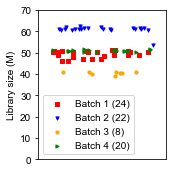

In [5]:
dat = pd.read_csv("results/prepare/star/mapped_all_log.tsv", sep="\t", index_col=0)

ys = dat["Number of input reads"].values / 1e6
xs = np.random.rand(len(ys)) * 0.8 + 0.1

batches = []
for sample in dat.index:
    path1 = "data/datasets/%s_R1.fastq.gz" % sample
    path2 = os.readlink(path1)
    if "F20FTSCCKF0955_FISgaaE" in path2:
        batches.append(0)
    elif "F20FTSCCKF1558_YUocvE" in path2:
        batches.append(1)
    elif "F21FTSCCKF2946_SERvuzhR" in path2:
        batches.append(2)
    else:
        batches.append(3)

xs1 = []
ys1 = []
xs2 = []
ys2 = []
xs3 = []
ys3 = []
xs4 = []
ys4 = []
for x, y, b in zip(xs, ys, batches):
    if b == 0:
        xs1.append(x)
        ys1.append(y)
    elif b == 1:
        xs2.append(x)
        ys2.append(y)
    elif b == 2:
        xs3.append(x)
        ys3.append(y)
    else:
        xs4.append(x)
        ys4.append(y)
        
plt.figure(figsize=(2.5, 2.5))
plt.scatter(xs1, ys1, color="red", marker="s", s=10, label="Batch 1 (%d)" % len(xs1))
plt.scatter(xs2, ys2, color="blue", marker="v", s=10, label="Batch 2 (%d)" % len(xs2))
plt.scatter(xs3, ys3, color="orange", marker="o", s=10, label="Batch 3 (%d)" % len(xs3))
plt.scatter(xs4, ys4, color="green", marker=">", s=10, label="Batch 4 (%d)" % len(xs4))

plt.xlim(0, 1)
plt.xticks([])
plt.ylim(0, 70)
plt.yticks(np.arange(0, 80, 10))
plt.ylabel("Library size (M)")
plt.legend(frameon=True)

plt.tight_layout()
plt.savefig("figures/prepare.raw_read.scatter.png", dpi=300)